In [20]:
import os, sys

# find repo root (looks for liars_poker/ or pyproject.toml)
def find_repo_root(start_dir: str) -> str:
    cur = os.path.abspath(start_dir)
    for _ in range(6):
        if os.path.isdir(os.path.join(cur, "liars_poker")) or os.path.exists(os.path.join(cur, "pyproject.toml")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(os.path.join(start_dir, "..", ".."))

NB_DIR = os.getcwd()
REPO_ROOT = find_repo_root(NB_DIR)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

ARTIFACTS_ROOT = os.path.join(REPO_ROOT, "artifacts")
os.makedirs(ARTIFACTS_ROOT, exist_ok=True)

print("repo root   :", REPO_ROOT)
print("artifacts   :", ARTIFACTS_ROOT)


repo root   : c:\Users\adidh\Documents\liars_poker
artifacts   : c:\Users\adidh\Documents\liars_poker\artifacts


In [21]:
from liars_poker.core import GameSpec
from liars_poker.env import Rules
from liars_poker.algo.br_exact import best_response_exact
from liars_poker.training.psro import psro_loop, default_sampling_plan, SampleRequest, PSROState
from liars_poker.training.dense_fsp import dense_fsp_loop
from liars_poker.algo.br_exact_dense_to_dense import best_response_dense
from liars_poker.algo.psro import PSROState, nash_solver
from liars_poker.policies.tabular_dense import DenseTabularPolicy, mix_dense
from liars_poker.policies.population_mixture import PopulationMixturePolicy


import numpy as np

In [22]:
spec = GameSpec(ranks=5, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True)
rules = Rules(spec)
initial_pol = DenseTabularPolicy(spec)

In [23]:
def best_response_exact_wrapper(spec, mixed_pol: PopulationMixturePolicy, debug) -> DenseTabularPolicy:
    if not isinstance(mixed_pol, PopulationMixturePolicy):
        raise TypeError("Expected PopulationMixturePolicy.")
    policies = list(mixed_pol.policies)
    weights = np.asarray(mixed_pol.weights, dtype=float)
    if len(policies) == 0:
        raise ValueError("PopulationMixturePolicy has no policies.")
    if len(policies) != len(weights):
        raise ValueError("PopulationMixturePolicy weights mismatch.")
    for idx, pol in enumerate(policies):
        if not isinstance(pol, DenseTabularPolicy):
            raise TypeError(f"Component {idx} is not DenseTabularPolicy.")

    from liars_poker.policies.tabular_dense import mix_dense_multiple
    return best_response_dense(spec, mix_dense_multiple(policies, weights), debug)


In [24]:
# psro_state, summary = psro_loop(
#     spec=spec, iterations=400, 
#     oracle_first=best_response_exact_wrapper, oracle_second=best_response_exact_wrapper, 
#     meta_solver_fn=nash_solver, episodes_per_entry=1000, 
#     initial_first=initial_pol, initial_second=initial_pol, 
#     sampling_plan=default_sampling_plan, debug=True
# )



In [58]:
prune_cfg = {
    "max_size": 100,
    "min_size": 40,
    "recent_keep": 5,
    "inactive_window": 5,
    "prune_every": 1,

}
psro_state_try4, summary4 = psro_loop(
    spec=spec, iterations=400,
    oracle_first=best_response_exact_wrapper, oracle_second=best_response_exact_wrapper,
    meta_solver_fn=nash_solver, episodes_per_entry=1000, 
    initial_first=initial_pol, initial_second=initial_pol, 
    sampling_plan=default_sampling_plan, prune_cfg=prune_cfg,
    debug=True

)

s1: [1.]
s2: [1.]

Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.882435, second=0.852022, avg=0.867229)
Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.882435, second=0.852022, avg=0.867229)
s1: [0. 1.]
s2: [0. 1.]

Solving (dense-to-dense exact BR)...


c:\Users\adidh\Documents\liars_poker\liars_poker\algo\br_exact_dense_to_dense.py:134: RuntimeWarning: invalid value encountered in divide
  values = np.where(M > 0.0, WM / M, 0.0)
c:\Users\adidh\Documents\liars_poker\liars_poker\algo\br_exact_dense_to_dense.py:194: RuntimeWarning: invalid value encountered in divide
  values = np.where(best_m > 0.0, best_wm / best_m, 0.0)


Done. exploitability(first=0.712418, second=0.662951, avg=0.687685)
Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.712418, second=0.662951, avg=0.687685)
s1: [0. 0. 1.]
s2: [0. 0. 1.]

Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.945511, second=0.757620, avg=0.851565)
Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.945511, second=0.757620, avg=0.851565)
s1: [0.         0.41947768 0.44146855 0.13905377]
s2: [0.         0.39149584 0.31843922 0.29006494]

Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.764642, second=0.646805, avg=0.705724)
Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.773255, second=0.631626, avg=0.702441)
s1: [0. 0. 0. 0. 1.]
s2: [0. 0. 0. 0. 1.]

Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.841211, second=0.851118, avg=0.846164)
Solving (dense-to-dense exact BR)...
Done. exploitability(first=0.850224, second=0.848916, avg=0.849570)
s1: [0.         0.1866

In [ ]:
temp = [(i['oracle_first_exploitability'], i['oracle_second_exploitability']) for i in summary['logs']['iterations']]
y = []
# Initialize running minimums to infinity
min_p1 = float('inf')
min_p2 = float('inf')

for x in temp:
    # Update the running minimum for the first component
    p1_val = x[0]['p_first']
    if p1_val < min_p1:
        min_p1 = p1_val
        
    # Update the running minimum for the second component
    p2_val = x[1]['p_second']
    if p2_val < min_p2:
        min_p2 = p2_val
    
    # Calculate the average of the best-seen-so-far for both
    y.append((min_p1 + min_p2) / 2)
z = [(i[0]['p_first'] + i[1]['p_second'])/2 for i in temp]

# Convert PSRO exploitability series into the FSP-style log format
psro_info_min = {"exploitability_series": [{"predicted_avg": v} for v in y]}
psro_info = {"exploitability_series": [{"predicted_avg": v} for v in z]}

In [49]:
temp = [(i['oracle_first_exploitability'], i['oracle_second_exploitability']) for i in summary2['logs']['iterations']]
y = []
# Initialize running minimums to infinity
min_p1 = float('inf')
min_p2 = float('inf')

for x in temp:
    # Update the running minimum for the first component
    p1_val = x[0]['p_first']
    if p1_val < min_p1:
        min_p1 = p1_val
        
    # Update the running minimum for the second component
    p2_val = x[1]['p_second']
    if p2_val < min_p2:
        min_p2 = p2_val
    
    # Calculate the average of the best-seen-so-far for both
    y.append((min_p1 + min_p2) / 2)
z = [(i[0]['p_first'] + i[1]['p_second'])/2 for i in temp]

# Convert PSRO exploitability series into the FSP-style log format
psro_info_min2 = {"exploitability_series": [{"predicted_avg": v} for v in y]}
psro_info2 = {"exploitability_series": [{"predicted_avg": v} for v in z]}

In [56]:
temp = [(i['oracle_first_exploitability'], i['oracle_second_exploitability']) for i in summary3['logs']['iterations']]
y = []
# Initialize running minimums to infinity
min_p1 = float('inf')
min_p2 = float('inf')

for x in temp:
    # Update the running minimum for the first component
    p1_val = x[0]['p_first']
    if p1_val < min_p1:
        min_p1 = p1_val
        
    # Update the running minimum for the second component
    p2_val = x[1]['p_second']
    if p2_val < min_p2:
        min_p2 = p2_val
    
    # Calculate the average of the best-seen-so-far for both
    y.append((min_p1 + min_p2) / 2)
z = [(i[0]['p_first'] + i[1]['p_second'])/2 for i in temp]

# Convert PSRO exploitability series into the FSP-style log format
psro_info_min3 = {"exploitability_series": [{"predicted_avg": v} for v in y]}
psro_info3 = {"exploitability_series": [{"predicted_avg": v} for v in z]}

In [59]:
temp = [(i['oracle_first_exploitability'], i['oracle_second_exploitability']) for i in summary4['logs']['iterations']]
y = []
# Initialize running minimums to infinity
min_p1 = float('inf')
min_p2 = float('inf')

for x in temp:
    # Update the running minimum for the first component
    p1_val = x[0]['p_first']
    if p1_val < min_p1:
        min_p1 = p1_val
        
    # Update the running minimum for the second component
    p2_val = x[1]['p_second']
    if p2_val < min_p2:
        min_p2 = p2_val
    
    # Calculate the average of the best-seen-so-far for both
    y.append((min_p1 + min_p2) / 2)
z = [(i[0]['p_first'] + i[1]['p_second'])/2 for i in temp]

# Convert PSRO exploitability series into the FSP-style log format
psro_info_min4 = {"exploitability_series": [{"predicted_avg": v} for v in y]}
psro_info4 = {"exploitability_series": [{"predicted_avg": v} for v in z]}

In [33]:
pol, info = dense_fsp_loop(spec, 400, episodes_test=0, efficient=True)

Predicted exploitability: avg=0.867228717 (first=0.8824, second=0.8520)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.758406242 (first=0.7688, second=0.7481)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.729671722 (first=0.7515, second=0.7079)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.716491481 (first=0.7405, second=0.6925)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.703016955 (first=0.7280, second=0.6780)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.687968914 (first=0.7069, second=0.6691)
Sampled exploitability: avg=0.0000 (BR as P1=0.0000, BR as P2=0.0000), chi2 p-value=nan

Predicted exploitability: avg=0.67

In [61]:

z

[0.8672287170583534,
 0.6876848985208117,
 0.8515651874785002,
 0.6981339951078537,
 0.8450636394908841,
 0.6843684234174313,
 0.7321959499434918,
 0.6561804306285817,
 0.714508542106737,
 0.6487598239316643,
 0.6545475781634571,
 0.656982036097037,
 0.6342523559639776,
 0.6498741920726883,
 0.6060568931552649,
 0.6179996932089433,
 0.5901152435550385,
 0.5846602412073902,
 0.5841277379790997,
 0.5756296893243935,
 0.6052156705114944,
 0.5689296611577225,
 0.5947187498274513,
 0.5645955519901995,
 0.5732608705712572,
 0.5786481275140776,
 0.573116361835858,
 0.552377847836621,
 0.5706981898079495,
 0.5551849312742982,
 0.5577727866608806,
 0.5522552796859972,
 0.5535516410820336,
 0.5600230508606326,
 0.5512990764498529,
 0.54700960047502,
 0.5446944114994243,
 0.5453104001349812,
 0.5455546793589507,
 0.5379726304802651,
 0.540005974992767,
 0.5476295547751463,
 0.5383283920178609,
 0.5321001775618246,
 0.5328623902132411,
 0.5375874428319852,
 0.5401608183790956,
 0.5353316686527837,

<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

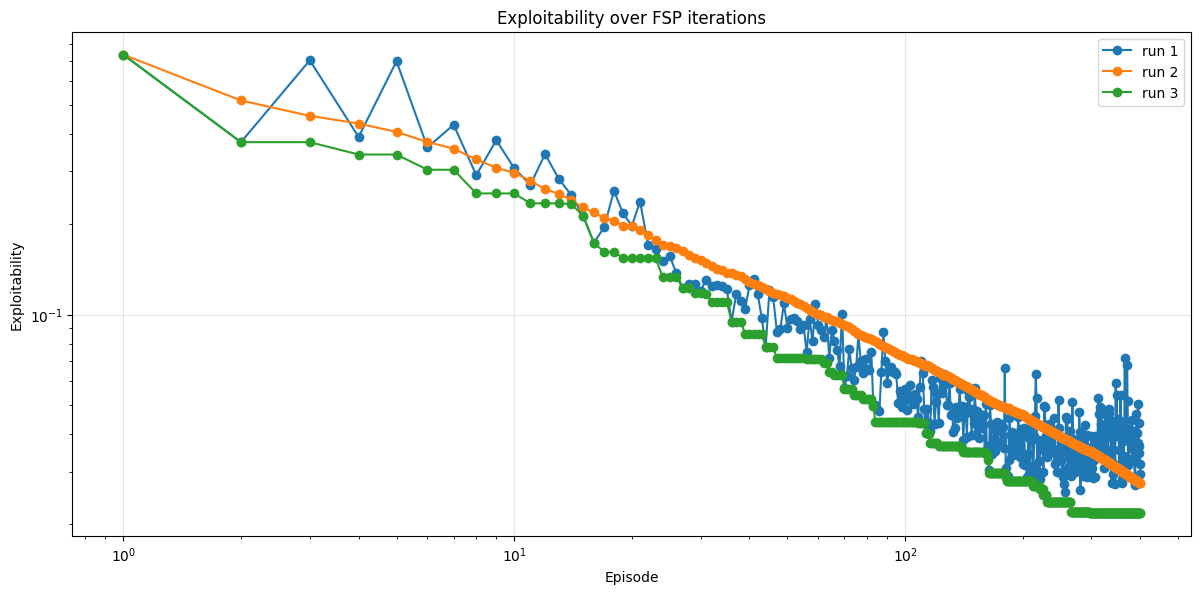

In [45]:
from liars_poker.training.fsp_utils import plot_exploitability_series as plot_fsp_exploitability_series
plot_fsp_exploitability_series([psro_info, info, psro_info_min])


<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

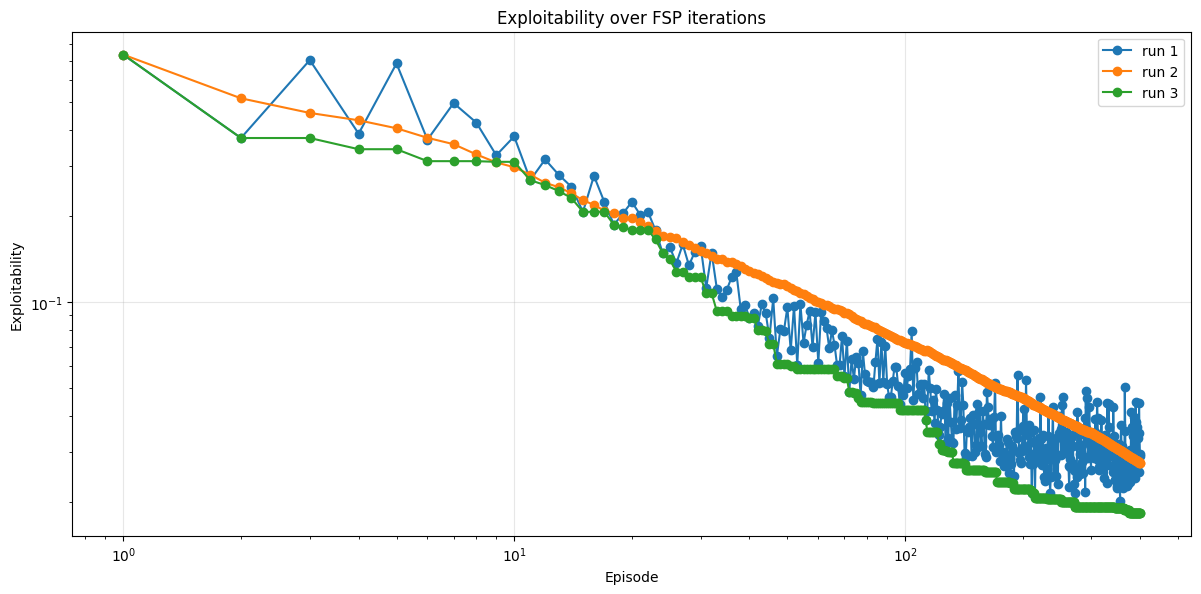

In [50]:
plot_fsp_exploitability_series([psro_info2, info, psro_info_min2])

<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

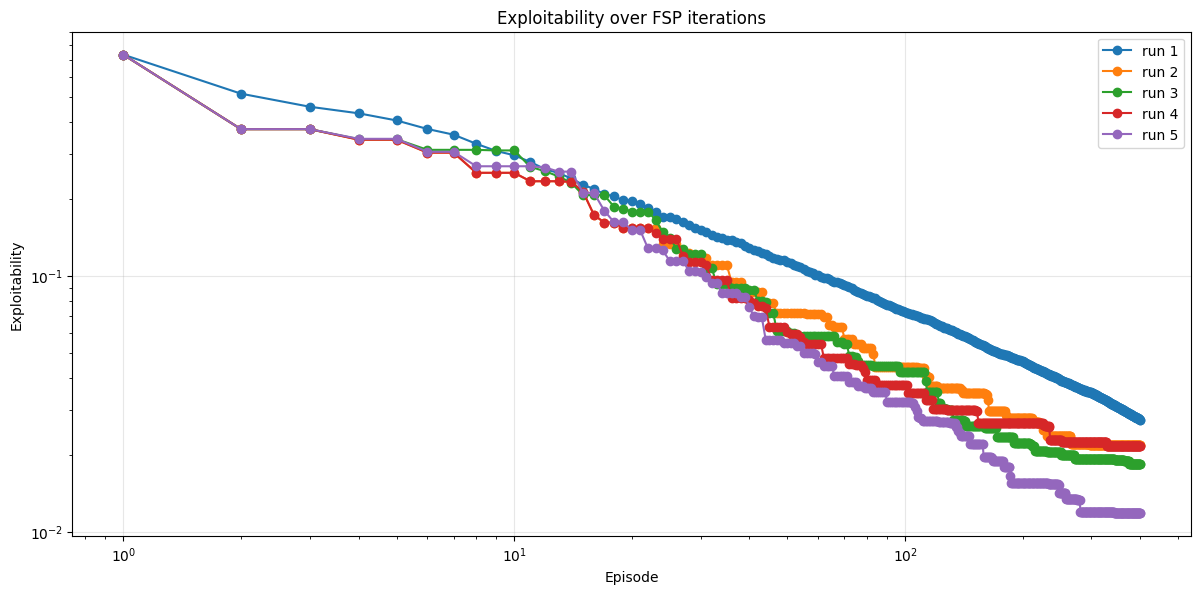

In [60]:
plot_fsp_exploitability_series([info, psro_info_min, psro_info_min2, psro_info_min3, psro_info_min4])